In [1]:
### Change Point Model ###
from change_detection import ChangePointDetector
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
import sys 
sys.path.append('../../../')
from main import Manager 
m = Manager('../../../')
from bin.plots.volume_oi_chart import price_volume_oi_chart
from bin.utils.tools import pretty_print

2025-04-28 17:01:05,025 - bin.options.optgd.db_connect - INFO - Options DB Initialized
2025-04-28 17:01:05,026 - bin.options.optgd.db_connect - WARNING - You currently have 8 connections open.
2025-04-28 17:01:05,028 - INFO - PriceDB Initialized successfully at 2025-04-28 17:01:05.028852
2025-04-28 17:01:05,028 - bin.price.db_connect - INFO - PriceDB Initialized successfully at 2025-04-28 17:01:05.028852
2025-04-28 17:01:05,029 - INFO - Established 3 database connections
2025-04-28 17:01:05,029 - bin.price.db_connect - INFO - Established 3 database connections
2025-04-28 17:01:05,107 - bin.alerts.options_alerts - INFO - Notifications instance initialized.


In [3]:
def get_aligned(stock):
    price_df = m.Pricedb.ohlc(stock)
    price_df =price_df.resample('1D').last()
    d = m.Optionsdb.get_daily_option_stats(stock)
    d = d.resample('1D').last()
    price_df = price_df.loc[d.index].dropna()
    d = d.loc[price_df.index].dropna()
    return price_df, d

def plot_model(stock, column):
    price_df, d = get_aligned(stock)
    df = d[column].sort_index().dropna().copy()
    detector = ChangePointDetector(df, scale=True, period=3, window_size=30)  # Adjusted window_size to 20 for better sensitivity
    # Optimized parameters
    best_params, best_result = detector.optimize_parameters(
        sensitivity_range=(0.01, 0.9, 0.01),
        threshold_range=(0.1, 2.0, 0.1), 
        min_triggers=4, 
        max_triggers=30
    )
    # print("\nBest Parameters:")
    # print(best_params)
    # print(f"Triggers: {best_result['Signal'].sum()}")

    best_params['Hits'] = best_result['Signal'].sum()
    best_params['threshold'] = best_result['S_T'].quantile(0.85)

    title_text = f"{stock.upper()} {df.name} - Change Point Detection\n" \
                f"Best Parameters: {best_params}"

    fig, ax = plt.subplots(2,1, figsize=(5, 5), height_ratios=[1, 0.5])
    ax[0].set_title(title_text)
    ax[0].plot(df.index, df.values, color='blue', linewidth=1)
    ax[1].plot(best_result.index, best_result['S_T'], linewidth=1, color='red', label='S_T')
    ax[1].hlines(best_params['threshold'], xmin=best_result.index[0], xmax=best_result.index[-1], color='green', linestyle='--', label='Threshold')

    # Scatter plot the change points
    for i in range(len(best_result)):
        if best_result['Signal'][i] == 1:
            ax[0].scatter(df.index[i], df.values[i], color='red', s=50, label='Change Point')


    fig.tight_layout()
    fig.autofmt_xdate()
    return price_df, d, best_result


In [4]:
from trend_results import TResults
tr = TResults(
    connections = '../../../',
    lookback_days= 90,
    window_size = 200, 
    period = 30
    
    )


2025-04-28 17:01:10,310 - bin.options.optgd.db_connect - INFO - Options DB Initialized
2025-04-28 17:01:10,310 - bin.options.optgd.db_connect - WARNING - You currently have 8 connections open.
2025-04-28 17:01:10,314 - INFO - PriceDB Initialized successfully at 2025-04-28 17:01:10.314194
2025-04-28 17:01:10,314 - bin.price.db_connect - INFO - PriceDB Initialized successfully at 2025-04-28 17:01:10.314194
2025-04-28 17:01:10,315 - INFO - Established 3 database connections
2025-04-28 17:01:10,315 - bin.price.db_connect - INFO - Established 3 database connections
2025-04-28 17:01:10,380 - bin.alerts.options_alerts - INFO - Notifications instance initialized.


In [5]:
results = tr.analyze_stocks()

Processing gdx:   0%|          | 0/184 [00:00<?, ?it/s]  

Processing nvo: 100%|██████████| 184/184 [04:08<00:00,  1.35s/it, Success=1]


In [6]:

results[0] + results[1]

[TrendResult(stock='gdx', name='close_prices', trend_direction='up', seasonality='normal', slope=0.005071590704191832, change_point=0.0),
 TrendResult(stock='gdx', name='stock_volume', trend_direction='down', seasonality='normal', slope=0.013921269537703647, change_point=1.0),
 TrendResult(stock='gdx', name='options_volume', trend_direction='down', seasonality='normal', slope=-0.0009358325275817409, change_point=0.0),
 TrendResult(stock='gdx', name='oi', trend_direction='down', seasonality='normal', slope=-0.0008241954848480055, change_point=0.0),
 TrendResult(stock='gdx', name='atm_iv', trend_direction='up', seasonality='normal', slope=0.00017436074301469594, change_point=0.0),
 TrendResult(stock='gdx', name='call_oi', trend_direction='down', seasonality='normal', slope=-0.0008149723867336709, change_point=0.0),
 TrendResult(stock='gdx', name='put_oi', trend_direction='down', seasonality='normal', slope=-0.0008458386345091793, change_point=0.0),
 TrendResult(stock='gdx', name='call_vo

In [7]:
# Convert to DataFrame
data = []
for i in results:
    for result in i:
        data.append({
            'stock': result.stock,
            'metric': result.name,
            'trend_direction': result.trend_direction,
            'seasonality': result.seasonality,
            'slope': result.slope,
            'change_point': result.change_point
        })
df = pd.DataFrame(data)

# Flag slope discrepancies (where trend direction and slope sign don't match)
df['slope_discrepancy'] = ((df['trend_direction'] == 'up') & (df['slope'] < 0)) | ((df['trend_direction'] == 'down') & (df['slope'] > 0))
print("DataFrame with Slope Discrepancies Flagged:")
df[df.slope_discrepancy == True]

DataFrame with Slope Discrepancies Flagged:


,stock,metric,trend_direction,seasonality,slope,change_point,slope_discrepancy
1,gdx,stock_volume,down,normal,0.013921,1.0,True
9,gme,close_prices,up,low,-0.002562,1.0,True
10,gme,stock_volume,down,high,0.006229,0.0,True
19,amzn,stock_volume,down,normal,0.009043,0.0,True
20,amzn,options_volume,up,high,-0.001638,0.0,True
...,...,...,...,...,...,...,...
1604,btu,options_volume,down,normal,0.006038,0.0,True
1605,btu,oi,down,high,0.010706,1.0,True
1607,btu,call_oi,down,high,0.011521,1.0,True
1609,btu,call_volume,down,low,0.010781,0.0,True


In [8]:
df.metric.unique()

array(['close_prices', 'stock_volume', 'options_volume', 'oi', 'atm_iv',
       'call_oi', 'put_oi', 'call_volume', 'put_volume'], dtype=object)

In [9]:
increasing_oi = df[(df.metric == 'oi') & (df.trend_direction == 'up')].stock.tolist()
decreasing_oi = df[(df.metric == 'oi') & (df.trend_direction == 'down')].stock.tolist()

increasing_options_volume = df[(df.metric == 'options_volume') & (df.trend_direction == 'up')].stock.tolist()
decreasing_options_volume = df[(df.metric == 'options_volume') & (df.trend_direction == 'down')].stock.tolist()

increasing_price_volume = df[(df.metric == 'price_volume') & (df.trend_direction == 'up')].stock.tolist()
decreasing_price_volume = df[(df.metric == 'price_volume') & (df.trend_direction == 'down')].stock.tolist()

increasing_price = df[(df.metric == 'close_prices') & (df.trend_direction == 'up')].stock.tolist()
decreasing_price = df[(df.metric == 'close_prices') & (df.trend_direction == 'down')].stock.tolist()
print("Increasing Options Volume:", increasing_options_volume)
print("Increasing Price:", increasing_price)


Increasing Options Volume: ['amzn', 'pfe', 'igv', 'uber', 'uup', 'pep', 'goog', 'mmm', 'dkng', 'mdb', 'ups', 'pltr', 'vxx', 'fcel', 'mu', 'enph', 'lc', 'bkkt', 'bno', 'wfc', 'crwd', 'mrk', 'qcom', 'tsla', 'sol', 'mos', 'msft', 'meta', 'abbv', 'moo', 'rblx', 'qqq', 'iei', 'nflx', 'pbw', 'xme', 'ebay', 'f', 'ibm', 'xly', 'xlp', 'amd', 'amc', 'xlv', 'bito', 'coin', 'rtx', 'afrm', 'gsl', 'ba', 'cmre', 'ctva', 'csco', 'cvs', 'icln', 'snow', 'fang', 'tsn', 'iwm', 'weat', 'tan', 'clx', 'jpm', 'hood', 'spot', 'afl', 'avgo', 'mpw', 'amat', 'panw', 'smci', 'rddt', 'dell', 'adbe', 'tost', 'oklo', 'tem']
Increasing Price: ['gdx', 'gme', 'spy', 'xlf', 'aapl', 'pfe', 'igv', 'uber', 'xli', 'ntr', 'mdb', 'xlu', 'ups', 'pltr', 'wmt', 'vale', 'mo', 'hd', 'shy', 'rrc', 'fdn', 'lc', 'jks', 'vuzi', 'bkkt', 'bno', 'wfc', 'crwd', 'baba', 'slv', 'qcom', 'mos', 'qs', 'tgt', 'abbv', 'moo', 'rblx', 'qqq', 'iei', 'nflx', 'pbw', 'ccj', 'xme', 'ebay', 'f', 'ief', 'sono', 'pypl', 'ibm', 'xlp', 'xle', 'xom', 'xlb', '

In [10]:
b = set(increasing_options_volume) & set(increasing_price)
print(b)

{'afl', 'bkkt', 'gsl', 'uber', 'bito', 'fang', 'moo', 'coin', 'igv', 'f', 'cmre', 'abbv', 'ups', 'pltr', 'snow', 'tost', 'iwm', 'pfe', 'ctva', 'ba', 'mpw', 'ibm', 'bno', 'crwd', 'nflx', 'adbe', 'rddt', 'rblx', 'tem', 'mdb', 'xlp', 'qcom', 'iei', 'ebay', 'afrm', 'icln', 'dell', 'xme', 'qqq', 'pbw', 'wfc', 'tsn', 'spot', 'jpm', 'mos', 'hood', 'tan', 'lc'}


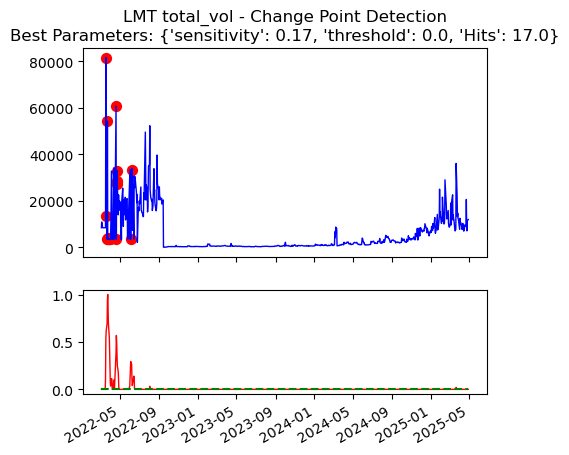

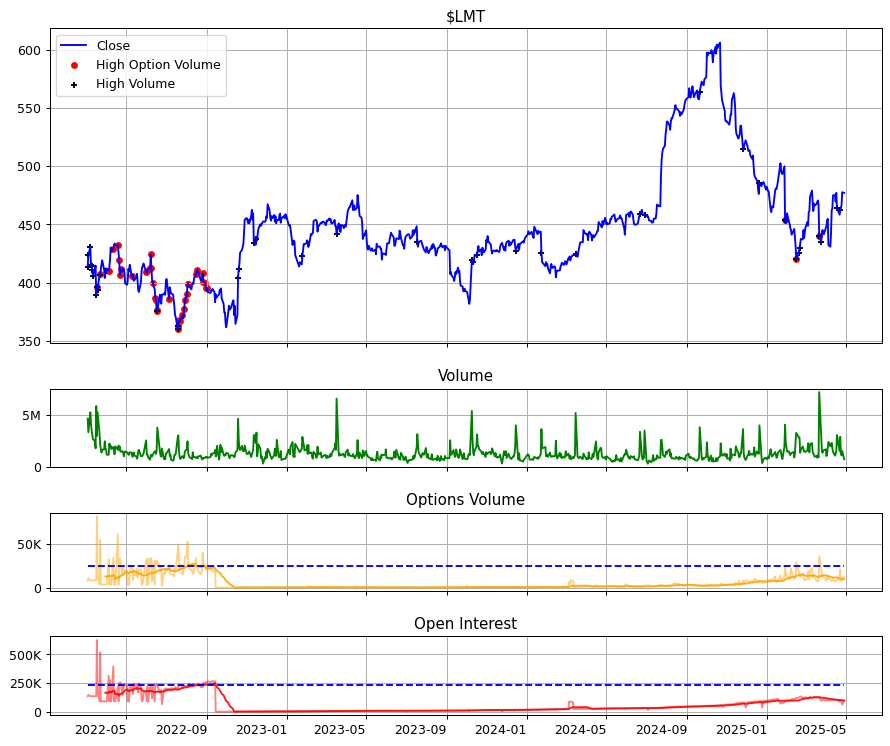

In [11]:
stock = 'lmt'; column = 'total_vol'
pdf, odf, result = plot_model(stock, column)
pdf.columns = [x.lower() for x in pdf.columns]
fig, ax = plt.subplots(4, 1, height_ratios=[2, 0.5, 0.5, 0.5], figsize = (10, 10), dpi = 90)
price_volume_oi_chart(odf, pdf, fig, ax, stock = stock)
fig.show()

In [15]:

pretty_print(odf[['total_vol', 'call_vol_chng', 'put_vol_chng', 'total_oi', 'call_oi_chng', 'put_oi_chng']])

,total_vol,call_vol_chng,put_vol_chng,total_oi,call_oi_chng,put_oi_chng
date,,,,,,
2022-03-03,"8,386.00","-78,286.00","-55,140.00","134,990.00","-167,708.00","-173,172.00"
2022-03-04,"10,856.00","2,236.00",234.00,"146,290.00","5,728.00","5,572.00"
2022-03-07,"8,386.00","-2,236.00",-234.00,"134,990.00","-5,728.00","-5,572.00"
2022-03-08,"8,386.00",0.00,0.00,"134,990.00",0.00,0.00
2022-03-09,"8,386.00",0.00,0.00,"134,990.00",0.00,0.00
...,...,...,...,...,...,...
2025-04-22,"20,582.00","7,361.00","4,258.00","93,242.00","2,386.00","3,152.00"
2025-04-23,"8,824.00","-6,832.00","-4,926.00","98,129.00","2,829.00","2,058.00"
2025-04-24,"7,035.00","-1,126.00",-663.00,"99,332.00","1,088.00",115.00


In [13]:
df[df.stock == stock]

,stock,metric,trend_direction,seasonality,slope,change_point,slope_discrepancy
369,lmt,close_prices,down,normal,-0.000588,0.0,False
370,lmt,stock_volume,up,normal,0.004873,0.0,False
371,lmt,options_volume,down,low,-0.002241,0.0,False
372,lmt,oi,down,normal,-0.001307,0.0,False
373,lmt,atm_iv,down,normal,-0.000294,0.0,False
374,lmt,call_oi,down,normal,-0.001187,0.0,False
375,lmt,put_oi,down,normal,-0.001530,0.0,False
376,lmt,call_volume,down,normal,-0.002400,0.0,False
377,lmt,put_volume,down,low,-0.002040,0.0,False


In [14]:
result['S_T'].quantile(.95)

0.0